# MUR L2 vs OISSTV2.1 vs UKmet

These may be the three most reasonable comparisons of synthesized daily products.  There are direct satellite products to compare as well.


In [51]:
import xarray as xa
from erddapy import ERDDAP
import pandas as pd
import datetime

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

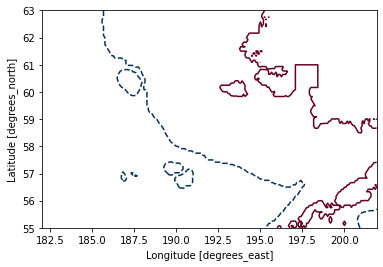

In [3]:
# get bathymetry and add 70m or 50m line
server_url = 'http://akutan.pmel.noaa.gov:8080/erddap/griddap/etopo5'
bathy = xa.open_dataset(server_url) 

bathy_sub = bathy.sel(latitude=slice(55,63),longitude=slice(182,202))
bathy_sub.ROSE.plot.contour(levels=[0,-70])

## Single Day Area Comparison

In [8]:
sstfiles = '/Volumes/MobileSSD/in_and_outbox/data_sets/noaa.oisst.v2.highres/'
xdf = xa.load_dataset(sstfiles+'sst.day.mean.2003.v2.nc')

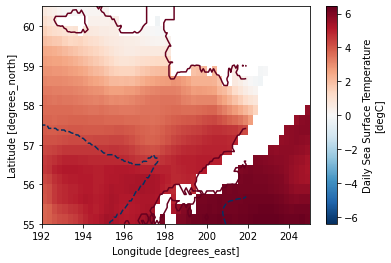

In [9]:
xdfs = xdf.sel(time=slice("2003-01-01", "2003-01-01"),lat=slice(55,60.5),lon=slice(180+(180-168),180+(180-155)))
xdfs.sst.plot()
bathy_sub.ROSE.plot.contour(levels=[0,-70])

In [10]:
sstfiles = '/Volumes/MobileSSD/in_and_outbox/data_sets/noaa.oisst.v2.highres/'
xdf = xa.load_dataset(sstfiles+'sst.day.mean.2003.nc')

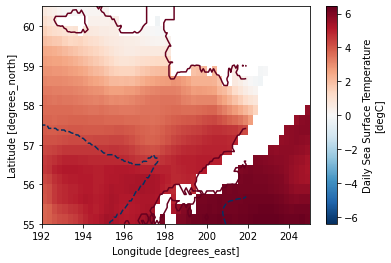

In [11]:
xdfs = xdf.sel(time=slice("2003-01-01", "2003-01-01"),lat=slice(55,60.5),lon=slice(180+(180-168),180+(180-155)))
xdfs.sst.plot()
bathy_sub.ROSE.plot.contour(levels=[0,-70])

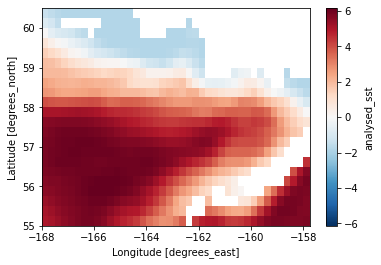

In [18]:
sstfiles = '/Volumes/MobileSSD/in_and_outbox/data_sets/podaac_MUR/SEBering/'
xdf = xa.load_dataset(sstfiles+'20030101090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2_subset.nc')
xdfs = xdf.sel(time=slice("2003-01-01", "2003-01-01"),lat=slice(55,60.5),lon=slice(-168,-155))
(xdfs['analysed_sst']-273.15).plot()
bathy_sub.ROSE.plot.contour(levels=[0,-70])

In [16]:
xdf

<xarray.Dataset>
Dimensions:           (lat: 34, lon: 78, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2003-01-01T09:00:00
  * lat               (lat) float32 54.88 55.12 55.38 ... 62.62 62.88 63.12
  * lon               (lon) float32 -177.1 -176.9 -176.6 ... -158.1 -157.9
Data variables:
    analysed_sst      (time, lat, lon) float32 276.3 276.2 276.2 ... nan nan nan
    analysis_error    (time, lat, lon) float32 0.38 0.38 0.37 ... nan nan nan
    mask              (time, lat, lon) float32 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0
    sea_ice_fraction  (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... nan nan nan
    sst_anomaly       (time, lat, lon) float32 -0.382 -0.47 -0.415 ... nan nan
Attributes: (12/54)
    Conventions:                CF-1.7, ACDD-1.3
    title:                      Daily 0.25-degree MUR SST, Final product
    summary:                    A low-resolution version of the MUR SST analy...
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    ...                         ...
    publisher_name:             GHRSST Project Office
    publisher_url:              https://www.ghrsst.org
    publisher_email:            gpc@ghrsst.org
    file_quality_level:         3
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    acknowledgment:             Please acknowledge the use of these data with...

### Timeseries at M2

pulling down all years V2 vs v2.1

In [14]:
m2point=[56.867,-164.05]

#mur
sstfiles = '/Volumes/MobileSSD/in_and_outbox/data_sets/podaac_MUR/SEBering/'
xdf = xa.open_mfdataset(sstfiles+'201[89]*.nc')

m2mur = xdf.sel(lat=m2point[0],lon=m2point[1], method="nearest").load()

m2point=[56.867,180+(180-164.05)]
sstfiles = '/Volumes/MobileSSD/in_and_outbox/data_sets/noaa.oisst.v2.highres/'
xdf = xa.open_mfdataset(sstfiles+'sst.day.mean.201[89].v2.nc')

m2oisst = xdf.sel(lat=m2point[0],lon=m2point[1], method="nearest").load()

m2oisst.sst.plot()
(m2mur.analysed_sst-273.15).plot()

Load some M2 nearsfc data

In [57]:
server_url='http://akutan.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

df = pd.read_csv(e.get_search_url(response='csv', search_for='bsitaepr2a -prawler'))


dfm2 = {}
for dataset_id in sorted(df['Dataset ID'].values):
    if  not ('gridded' in dataset_id) and not ('Met' in dataset_id):
        print(dataset_id)
        try:
            e = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv'
            )
            e.dataset_id=dataset_id
        except HTTPError:
            print('Failed to generate url {}'.format(dataset_id))
            continue
        try:
            dftemp = e.to_pandas(
                                index_col='time (UTC)',
                                parse_dates=True,
                                skiprows=(1,)  # units information can be dropped.
                                )
            dftemp.columns = [x[1].split()[0] for x in enumerate(dftemp.columns)]

            ##resample as daily data 
            dfm2.update({dataset_id: dftemp})
        except:
            pass

datasets_Mooring_18bsitaepr2a_preliminary
datasets_Mooring_19bsitaepr2a_final
datasets_Mooring_19bsitaepr2a_preliminary


(17897.0, 18262.0)

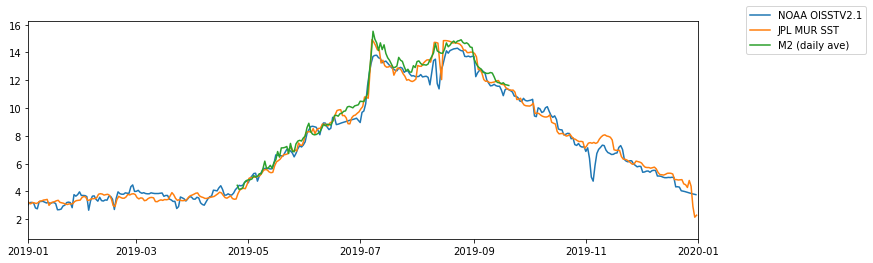

In [55]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = plt.plot(m2oisst.time,m2oisst.sst,label='NOAA OISSTV2.1')
ax = plt.plot(m2mur.time,(m2mur.analysed_sst-273.15),label='JPL MUR SST')
dfm_surf=dfm2['datasets_Mooring_19bsitaepr2a_final'][dfm2['datasets_Mooring_19bsitaepr2a_final'].depth == 1].resample('1D').mean()
ax = plt.plot(dfm_surf.index,
              dfm_surf.temperature,label='M2 (daily ave)')
fig.legend(bbox_to_anchor=(0.95,.95), loc="upper left")

plt.xlim([datetime.date(2019,1,1),datetime.date(2020,1,1)])


(17532.0, 17897.0)

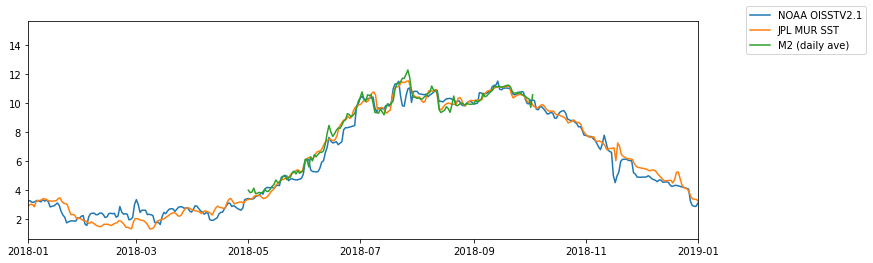

In [59]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = plt.plot(m2oisst.time,m2oisst.sst,label='NOAA OISSTV2.1')
ax = plt.plot(m2mur.time,(m2mur.analysed_sst-273.15),label='JPL MUR SST')
dfm_surf=dfm2['datasets_Mooring_18bsitaepr2a_preliminary'][dfm2['datasets_Mooring_18bsitaepr2a_preliminary'].depth == 0].resample('1D').mean()['2018-05':]
ax = plt.plot(dfm_surf.index,
              dfm_surf.temperature,label='M2 (daily ave)')
fig.legend(bbox_to_anchor=(0.95,.95), loc="upper left")

plt.xlim([datetime.date(2018,1,1),datetime.date(2019,1,1)])


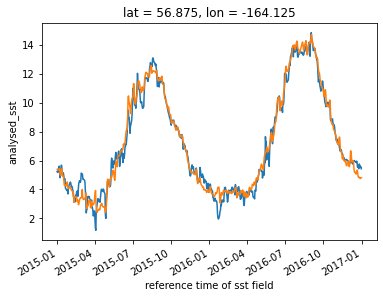

In [61]:
m2point=[56.867,-164.05]

#mur
sstfiles = '/Volumes/MobileSSD/in_and_outbox/data_sets/podaac_MUR/SEBering/'
xdf = xa.open_mfdataset(sstfiles+'201[56]*.nc')

m2mur = xdf.sel(lat=m2point[0],lon=m2point[1], method="nearest").load()

m2point=[56.867,180+(180-164.05)]
sstfiles = '/Volumes/MobileSSD/in_and_outbox/data_sets/noaa.oisst.v2.highres/'
xdf = xa.open_mfdataset(sstfiles+'sst.day.mean.201[56].v2.nc')

m2oisst = xdf.sel(lat=m2point[0],lon=m2point[1], method="nearest").load()

m2oisst.sst.plot()
(m2mur.analysed_sst-273.15).plot()

In [92]:
server_url='http://akutan.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

dfm2 = {}
for _,dataset_id in enumerate(['datasets_Mooring_15bsm2a_final','datasets_Mooring_16bsm2a_final']):
    if  not ('gridded' in dataset_id) and not ('Met' in dataset_id) and not ('preliminary' in dataset_id):
        print(dataset_id)
        try:
            e = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv'
            )
            e.dataset_id=dataset_id

        except HTTPError:
            print('Failed to generate url {}'.format(dataset_id))
            continue

        dftemp = e.to_pandas(
                            index_col='time (UTC)',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )
        dftemp.columns = [x[1].split()[0] for x in enumerate(dftemp.columns)]

        dfm2.update({dataset_id: dftemp})


datasets_Mooring_15bsm2a_final
datasets_Mooring_16bsm2a_final


In [98]:
dfm2['datasets_Mooring_16bsm2a_final'].depth.unique()

array([11., 24.,  4., 32., 60., 15., 18., 21., 28., 35., 39., 50., 47.,
       55.,  6., 44.,  3.])

(16436.0, 16801.0)

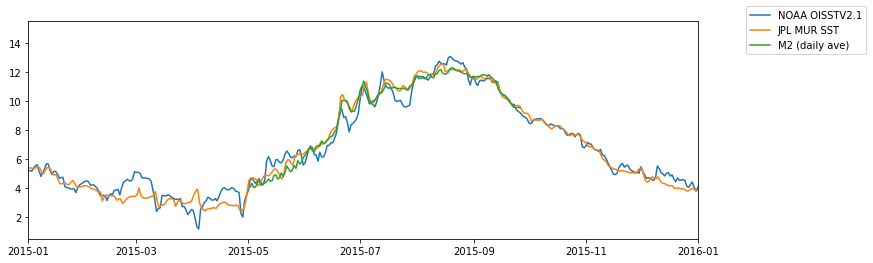

In [103]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = plt.plot(m2oisst.time,m2oisst.sst,label='NOAA OISSTV2.1')
ax = plt.plot(m2mur.time,(m2mur.analysed_sst-273.15),label='JPL MUR SST')
dfm_surf=dfm2['datasets_Mooring_15bsm2a_final'][dfm2['datasets_Mooring_15bsm2a_final'].depth == 4].resample('1D').mean()
ax = plt.plot(dfm_surf.index,
              dfm_surf.temperature,label='M2 (daily ave)')
fig.legend(bbox_to_anchor=(0.95,.95), loc="upper left")

plt.xlim([datetime.date(2015,1,1),datetime.date(2016,1,1)])


(16801.0, 17167.0)

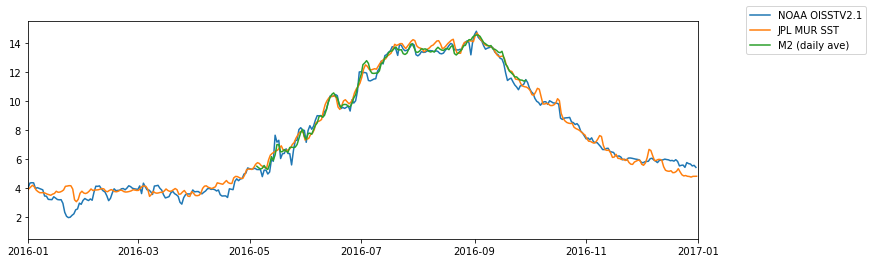

In [104]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = plt.plot(m2oisst.time,m2oisst.sst,label='NOAA OISSTV2.1')
ax = plt.plot(m2mur.time,(m2mur.analysed_sst-273.15),label='JPL MUR SST')
dfm_surf=dfm2['datasets_Mooring_16bsm2a_final'][dfm2['datasets_Mooring_16bsm2a_final'].depth == 4].resample('1D').mean()
ax = plt.plot(dfm_surf.index,
              dfm_surf.temperature,label='M2 (daily ave)')
fig.legend(bbox_to_anchor=(0.95,.95), loc="upper left")

plt.xlim([datetime.date(2016,1,1),datetime.date(2017,1,1)])
